# Object-Oriented Demo

---

How `climpred` would look with an object-oriented philosophy.

In [1]:
import numpy as np
import xarray as xr
import climpred as cp
import matplotlib.pyplot as plt
%matplotlib inline
#from climpred.prediction import (compute_reference, compute_persistence, 
#                                 compute_perfect_model, bootstrap_perfect_model)

# Perfect Model

---

An early demo of the `PerfectModelEnsemble` class. Horizon not yet implemented.

In [2]:
ds = xr.open_dataset('../sample_data/prediction/PM_MPI-ESM-LR_ds.nc')
control = xr.open_dataset('../sample_data/prediction/PM_MPI-ESM-LR_control.nc')

In [3]:
ds = ds.sel(period='ym', area='global')['tos']
control = control.sel(period='ym', area='global') \
                 .rename({'time': 'initialization'})['tos']

In [4]:
PM = cp.PerfectModelEnsemble(ds)
PM.add_control(control)
print(PM)

<climpred.PerfectModelEnsemble>
Initialized Ensemble:
    tos      (time, initialization, member) float32 ...
Control:
    tos      (initialization) float32 ...



In [5]:
def _get_limit_sig(metric='pearson_r',sig=99):
    """Adjust limit and significance level for bootstrapping to metric."""
    if metric in ['pearson_r', 'ppp', 'msss', 'nrmse', 'nmse']:
        limit = 'upper'
        sigl = sig
    else:
        limit = 'lower'
        sigl = 100 - sig
    return limit, sigl

def _plot_skill(ax, result, color='k', linestyle='-', marker='o', 
                markersize=6, linewidth=2, **kwargs):
    """
    Quick function to plot results of predictability analysis.
    """
    p = ax.plot(result.time, result, color=color, linestyle=linestyle, 
                marker=marker, markersize=markersize, linewidth=linewidth, 
                **kwargs)
    return p

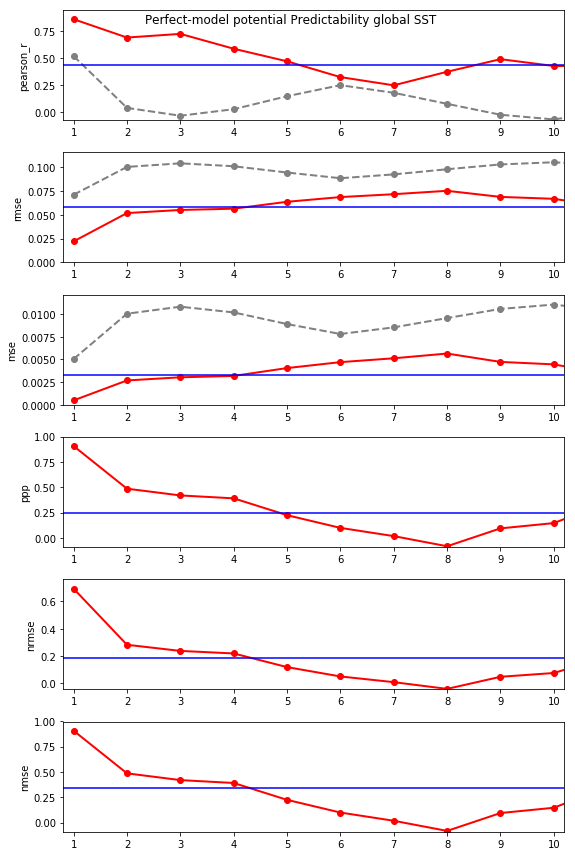

In [6]:
comparison='m2e'
sig=99
bootstrap=100
# Main plot.
metrics = ['pearson_r', 'rmse', 'mse', 'ppp', 'nrmse','nmse']
f, axs = plt.subplots(nrows=len(metrics), ncols=1,figsize=(8,12))

for ax, metric in zip(axs, metrics):
    ip = PM.compute_skill(metric=metric, comparison=comparison)['tos']
    limit, sig1 = _get_limit_sig(metric=metric, sig=sig)
    up = PM.bootstrap(metric=metric, comparison=comparison, sig=sig1)['tos']
    if metric in ['rmse', 'mse', 'pearson_r']:
        persist = PM.compute_persistence(metric=metric)['tos']
        persist['time'] = persist['time']
        p = _plot_skill(ax, persist, color='gray', linestyle='--', label='persistence forecast')
    i = _plot_skill(ax, ip, color='r', label='initialized forecast')
    u = ax.axhline(y=up, color='blue', linewidth=1.5, label='uninitialized forecast')

    fac = 1.1
    ax.set_ylim([fac * min(0, up, ip.min('time'),persist.min('time')),fac * max(up, ip.max('time'),persist.max('time'))])
    ax.set_xlim([0.8, 10.2])
    ax.set_xticks(np.arange(1.,11.),minor=False)
    ax.set_ylabel(metric)
    persist=persist-persist

plt.suptitle('Perfect-model potential Predictability global SST')

#plt.legend([i[0], p[0], u, php],ncol=2)
plt.tight_layout()

# REFERENCE ENSEMBLE STUFF

Load in demo datasets and process them

In [7]:
def _load_dple():
    dple = xr.open_dataset('/Users/ribr5703/Desktop/climpred/sample_data/prediction/' +
                     'CESM-DP-LE.SST.annmean.anom.nc')['anom']
    dple = dple.sel(S=slice(1955, 2015))
    dple = dple.mean('M')
    dple = dple.rename({'S': 'initialization', 'L': 'time'})
    dple.name = 'SST'
    return dple

def _load_fosi():
    fosi = xr.open_dataset('/Users/ribr5703/Desktop/climpred/sample_data/prediction/' +
                       'g.e11_LENS.GECOIAF.T62_g16.009.pop.h.SST.024901-031612.nc')['SST']
    fosi = fosi.sel(time=slice('1955', '2015'))
    fosi = fosi.groupby('time.year').mean('time')
    fosi = fosi.rename({'year': 'initialization'})
    return fosi

def _load_data():
    data = xr.open_dataset('/Users/ribr5703/Desktop/climpred/sample_data/prediction/' +
                           'ERSSTv4.global.mean.nc')['sst']
    data = data.rename({'year': 'initialization'})
    data.name = 'SST'
    return data

dple = _load_dple().to_dataset()
fosi = _load_fosi().to_dataset()
data = _load_data().to_dataset()

There are currently two types of objects (like `dataset` and `dataarray`). One is the `ReferenceEnsemble`, which are ensembles that are initialized off of something like a reconstruction or data. The other is a `PerfectModelEnsemble`, like MPI's setup.

In [9]:
dp = cp.ReferenceEnsemble(dple)
print(dp)

<climpred.ReferenceEnsemble>
Initialized Ensemble:
    SST      (initialization, time) float32 -0.20294695 -0.1434082 ... 0.587774
References:
    None


For a `ReferenceEnsemble` type, you can add multiple references. Here, we will add the reconstruction (FOSI) and a dataset (ERSST). Multiple checks go into play here under the hood, ensuring that dimensions are named according to our rules and that references match all initialized dimensions (except for `time`). 

We can also have multiple variables per reference and decadal prediction object.

In [10]:
dple['SALT'] = _load_dple()
fosi['SALT'] = ('initialization', np.random.randn(61))
data['SALT'] = ('initialization', np.random.randn(61))

In [12]:
dp = cp.ReferenceEnsemble(dple)
dp.add_reference(fosi, 'FOSI')
dp.add_reference(data, 'ERSST')
print(dp)

<climpred.ReferenceEnsemble>
Initialized Ensemble:
    SST      (initialization, time) float32 -0.20294695 -0.1434082 ... 0.587774
    SALT     (initialization, time) float32 -0.20294695 -0.1434082 ... 0.587774
FOSI:
    SST      (initialization) float32 16.255846 16.252129 ... 16.714994
    SALT     (initialization) float64 1.451 1.175 -0.5972 ... -0.4558 0.7476
ERSST:
    SST      (initialization) float32 ...
    SALT     (initialization) float64 1.009 -0.5156 1.273 ... -0.05187 -0.7829


Now we can apply our functions to our `ReferenceEnsemble` object. You can call `compute_skill` in two different ways:

1. Declaring a single reference you want to compute skill with regard to (this returns a single xr.Dataset with skill results for that

2. Running `compute_skill` with no arguments, which computes skill for all available references. This returns a dictionary with each of your reference results.

In [13]:
# only want skill for FOSI.
skill = dp.compute_skill('FOSI')
print(skill)

<xarray.Dataset>
Dimensions:  (time: 10)
Coordinates:
    z_t      float32 500.0
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
Data variables:
    SST      (time) float32 0.85391504 0.7564817 ... 0.7252849 0.7146723
    SALT     (time) float64 0.1057 0.1393 0.1675 0.1453 ... 0.1965 0.1876 0.1686


In [14]:
# want skill for all references
skill = dp.compute_skill()
print(skill['FOSI'])
print(skill['ERSST'])

<xarray.Dataset>
Dimensions:  (time: 10)
Coordinates:
    z_t      float32 500.0
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
Data variables:
    SST      (time) float32 0.85391504 0.7564817 ... 0.7252849 0.7146723
    SALT     (time) float64 0.1057 0.1393 0.1675 0.1453 ... 0.1965 0.1876 0.1686
<xarray.Dataset>
Dimensions:  (time: 10)
Coordinates:
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
Data variables:
    SST      (time) float32 0.92809033 0.8993258 ... 0.915254 0.91362256
    SALT     (time) float64 -0.1952 -0.1205 -0.124 ... -0.1474 -0.1216 -0.138


We can also compute a persistence forecast.

In [15]:
dp.compute_persistence('FOSI')

<xarray.Dataset>
Dimensions:  (time: 10)
Coordinates:
    z_t      float32 500.0
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
Data variables:
    SST      (time) float32 0.7159944 0.5045179 ... 0.44596496 0.5347486
    SALT     (time) float64 0.02889 0.06513 -0.02867 ... -0.1808 -0.0227 0.1341

In [16]:
persist = dp.compute_persistence()
print(persist['FOSI'])
print(persist['ERSST'])

<xarray.Dataset>
Dimensions:  (time: 10)
Coordinates:
    z_t      float32 500.0
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
Data variables:
    SST      (time) float32 0.7159944 0.5045179 ... 0.44596496 0.5347486
    SALT     (time) float64 0.02889 0.06513 -0.02867 ... -0.1808 -0.0227 0.1341
<xarray.Dataset>
Dimensions:  (time: 10)
Coordinates:
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
Data variables:
    SST      (time) float32 0.91231585 0.83529794 ... 0.83016926 0.8554033
    SALT     (time) float64 -0.08131 0.1777 0.04141 ... -0.2293 0.1292 -0.1371


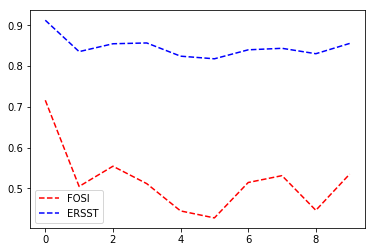

In [17]:
plt.plot(persist['FOSI'].SST, color='r', linestyle='--', label='FOSI')
plt.plot(persist['ERSST'].SST, color='b', linestyle='--', label='ERSST')
plt.legend()